In [1]:
import stim
import numpy as np
import matplotlib.pyplot as plt
import sinter
from typing import List
from ldpc import bposd_decoder
from tqdm import tqdm

In [2]:
def surface_code_10x_better(r, d, noise):
    circuit = stim.Circuit.generated(
                "surface_code:rotated_memory_z",
                rounds=r,
                distance=d,
                after_clifford_depolarization=noise,
                after_reset_flip_probability=noise/10,
                before_measure_flip_probability=noise,
                before_round_data_depolarization=noise*2,
            )
    # return circuit
    new_circuit = str(circuit).replace(f"DEPOLARIZE1({noise})", f"DEPOLARIZE1({noise/10})")
    new_circuit = new_circuit.replace(f"DEPOLARIZE1({noise*2})", f"DEPOLARIZE1({noise})")

    return stim.Circuit(new_circuit)

def surface_code(r, d, noise):
    circuit = stim.Circuit.generated(
                "surface_code:rotated_memory_z",
                rounds=r,
                distance=d,
                after_clifford_depolarization=noise,
                after_reset_flip_probability=noise,
                before_measure_flip_probability=noise,
                before_round_data_depolarization=noise,
            )
    return circuit


In [11]:
surface_code_tasks = [
    sinter.Task(
        circuit = surface_code_10x_better(r, d, noise),
        # circuit = surface_code_d4(r),
        # circuit = surface_code(r, d, noise),
        json_metadata={'d': d, 'r': r, 'p': noise},
    )
    for d in [8]
    # for r in [10,15,20,25,30,35,40,45,50,55,60,65,70,75,80]
    for r in [60,65,70,75,80]
    for noise in [0.001]
]

collected_surface_code_stats: List[sinter.TaskStats] = sinter.collect(
    num_workers=8,
    tasks=surface_code_tasks,
    decoders=['pymatching'],
    max_shots=50_000_000,
    max_errors=5_000,
    print_progress=True,
)

Starting 8 workers...
5 cases left:
    pymatching processes=5  ~core_mins_left=30      shots_left=49960000 errors_left=4996    {d=8,p=0.001,r=60}
    pymatching processes=3  ~core_mins_left=404     shots_left=49997000 errors_left=5000    {d=8,p=0.001,r=65}
    pymatching processes=0  ~core_mins_left=99      shots_left=49995500 errors_left=5000    {d=8,p=0.001,r=70}
    pymatching processes=0  ~core_mins_left=679     shots_left=49999500 errors_left=5000    {d=8,p=0.001,r=75}
    pymatching processes=0  ~core_mins_left=2475    shots_left=49999900 errors_left=5000    {d=8,p=0.001,r=80}
5 cases left:
    pymatching processes=6  ~core_mins_left=19      shots_left=49820800 errors_left=4991    {d=8,p=0.001,r=60}
    pymatching processes=2  ~core_mins_left=33      shots_left=49925000 errors_left=4993    {d=8,p=0.001,r=65}
    pymatching processes=0  ~core_mins_left=99      shots_left=49995500 errors_left=5000    {d=8,p=0.001,r=70}
    pymatching processes=0  ~core_mins_left=679     shots_left

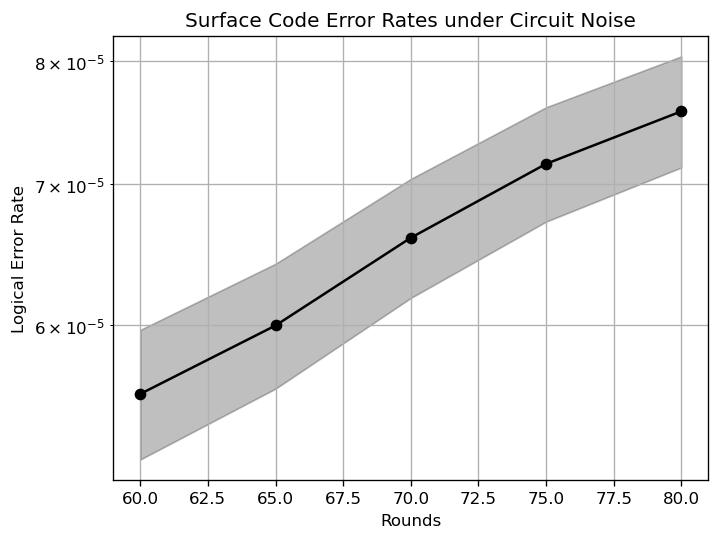

In [12]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_surface_code_stats,
    x_func=lambda stat: stat.json_metadata['r'],
    # group_func=lambda stat: stat.json_metadata['d'],
    # failure_units_per_shot_func=lambda stat: stat.json_metadata['r'],
)
# ax.set_ylim(5e-3, 5e-2)
# ax.set_xlim(0.008, 0.012)
ax.semilogy()
ax.set_title("Surface Code Error Rates under Circuit Noise")
ax.set_xlabel("Rounds")
ax.set_ylabel("Logical Error Rate")
ax.grid(which='major')
ax.grid(which='minor')
# ax.legend()
fig.set_dpi(120)  # Show it bigger

In [13]:
collected_surface_code_stats

[sinter.TaskStats(strong_id='05ecffd473bbe450aa9ffb2dbce5b78ecc903d6d85057e28b218c4283d09c2df', decoder='pymatching', json_metadata={'d': 8, 'r': 65, 'p': 0.001}, shots=50000000, errors=3000, seconds=917.1899999999987),
 sinter.TaskStats(strong_id='c230158b37c6e2dba41ed09e5cf2425750b87c1d20c40ea5f904c9662127ea3b', decoder='pymatching', json_metadata={'d': 8, 'r': 75, 'p': 0.001}, shots=50000000, errors=3576, seconds=1033.107),
 sinter.TaskStats(strong_id='fffd18d2db5141afaf54ec86410c8317e5a48830cfeb742e1b3dc391921ef8ab', decoder='pymatching', json_metadata={'d': 8, 'r': 60, 'p': 0.001}, shots=50000000, errors=2785, seconds=844.0940000000082),
 sinter.TaskStats(strong_id='8418f8bae8d7ddb22caf30a85c69ac56c151314041e8163adcd01ca9297ed054', decoder='pymatching', json_metadata={'d': 8, 'r': 70, 'p': 0.001}, shots=50000000, errors=3300, seconds=965.9390000000021),
 sinter.TaskStats(strong_id='f028009dac8c8bcde2cf9fddb13b3f058595d42137d3ff9576575817924ddf6a', decoder='pymatching', json_metada

In [14]:

for i, stat in enumerate(collected_surface_code_stats):
    shots = collected_surface_code_stats[i].shots
    errors = collected_surface_code_stats[i].errors
    print(errors/shots)
    # print(1-(1-(errors/shots))**8)

6e-05
7.152e-05
5.57e-05
6.6e-05
7.572e-05


In [85]:
circuit = stim.Circuit.generated(
            "surface_code:rotated_memory_z",
            rounds=1,
            distance=6,
            after_clifford_depolarization=0.001,
            after_reset_flip_probability=0.001,
            before_measure_flip_probability=0.001,
            before_round_data_depolarization=0.001,
        )
print(circuit.without_noise())

QUBIT_COORDS(1, 1) 1
QUBIT_COORDS(2, 0) 2
QUBIT_COORDS(3, 1) 3
QUBIT_COORDS(5, 1) 5
QUBIT_COORDS(6, 0) 6
QUBIT_COORDS(7, 1) 7
QUBIT_COORDS(9, 1) 9
QUBIT_COORDS(10, 0) 10
QUBIT_COORDS(11, 1) 11
QUBIT_COORDS(1, 3) 14
QUBIT_COORDS(2, 2) 15
QUBIT_COORDS(3, 3) 16
QUBIT_COORDS(4, 2) 17
QUBIT_COORDS(5, 3) 18
QUBIT_COORDS(6, 2) 19
QUBIT_COORDS(7, 3) 20
QUBIT_COORDS(8, 2) 21
QUBIT_COORDS(9, 3) 22
QUBIT_COORDS(10, 2) 23
QUBIT_COORDS(11, 3) 24
QUBIT_COORDS(0, 4) 26
QUBIT_COORDS(1, 5) 27
QUBIT_COORDS(2, 4) 28
QUBIT_COORDS(3, 5) 29
QUBIT_COORDS(4, 4) 30
QUBIT_COORDS(5, 5) 31
QUBIT_COORDS(6, 4) 32
QUBIT_COORDS(7, 5) 33
QUBIT_COORDS(8, 4) 34
QUBIT_COORDS(9, 5) 35
QUBIT_COORDS(10, 4) 36
QUBIT_COORDS(11, 5) 37
QUBIT_COORDS(12, 4) 38
QUBIT_COORDS(1, 7) 40
QUBIT_COORDS(2, 6) 41
QUBIT_COORDS(3, 7) 42
QUBIT_COORDS(4, 6) 43
QUBIT_COORDS(5, 7) 44
QUBIT_COORDS(6, 6) 45
QUBIT_COORDS(7, 7) 46
QUBIT_COORDS(8, 6) 47
QUBIT_COORDS(9, 7) 48
QUBIT_COORDS(10, 6) 49
QUBIT_COORDS(11, 7) 50
QUBIT_COORDS(0, 8) 52
QUBIT_CO

In [5]:
from scipy.sparse import lil_matrix

dem = circuit.flattened().detector_error_model()
pcm = lil_matrix((dem.num_detectors, dem.num_errors), dtype=np.uint8)
lcm = lil_matrix((dem.num_observables, dem.num_errors), dtype=np.uint8)

errors = []
channel_probs = [e.args_copy()[0] for e in circuit.flattened().detector_error_model() if e.type=="error"]
for i, error_event in enumerate(circuit.explain_detector_error_model_errors()):
    dets = [det.dem_target.val for det in error_event.dem_error_terms if det.dem_target.is_relative_detector_id()]
    obs = [ob.dem_target.val for ob in error_event.dem_error_terms if ob.dem_target.is_logical_observable_id()]
    pcm[[dets],i] = 1
    lcm[[obs],i] = 1

print(pcm.shape)
print(lcm.shape)

(400, 6859)
(1, 6859)


In [12]:
from ldpc import bp_decoder

bp_dec = bp_decoder(
    pcm,
    channel_probs=channel_probs,
    max_iter=pcm.shape[1],
    bp_method="msl",
    ms_scaling_factor=0
)

bposd_dec = bposd_decoder(
    pcm, # the parity check matrix
    channel_probs=channel_probs, #assign error_rate to each qubit. This will override "error_rate" input variable
    max_iter=pcm.shape[1], #the maximum number of iterations for BP)
    bp_method="msl",
    ms_scaling_factor=0, #min sum scaling factor. If set to zero the variable scaling factor method is used
    osd_method="osd_cs", #the OSD method. Choose from:  1) "osd_e", "osd_cs", "osd0"
    osd_order=min(pcm.shape[0],10) #the osd search depth
)

count = 0
num_iters = 1000

sampler = circuit.compile_detector_sampler()
for i in tqdm(range(num_iters)):
    detection_events, observable_flips = sampler.sample(1, separate_observables=True)
    guessed_errors = bposd_dec.decode(detection_events[0])
    guessed_obs = (lcm @ guessed_errors) % 2

    if not np.all(observable_flips[0].astype(int) == guessed_obs):
        count += 1
print(count/num_iters)

100%|██████████| 1000/1000 [00:33<00:00, 30.26it/s]

0.0
